# Problem 1
A static map of cycling accidents in Helsinki

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

In [2]:
# Import the data, select columns that are needed
fp ="data/tieliikenneonnettomuudet_2019_onnettomuus.csv"
data = pd.read_csv(fp, delimiter=";", usecols=["Onnett_id", "X", "Y", "Vakavuusko", "Vakavuus", "Onluokka", "Kuntasel", "Ontyyppi", "Ontyypsel", "Päivä"])





In [3]:
fp2 = "data/l_tiesto.shp"
roads = gpd.read_file(fp2)

fp3 = "data/m_meri_region.shp"
sea = gpd.read_file(fp3)

In [4]:
data.dtypes

Onnett_id       int64
Päivä          object
Vakavuusko      int64
Vakavuus       object
Ontyyppi        int64
Ontyypsel      object
Onluokka        int64
Kuntasel       object
X             float64
Y             float64
dtype: object

In [5]:
data


,Onnett_id,Päivä,Vakavuusko,Vakavuus,Ontyyppi,Ontyypsel,Onluokka,Kuntasel,X,Y
0,9332527,05.02.2019,0,Ei henkilövahinkoja,8,peräänajo liikenne-esteen takia pysäht. ajoneu...,6,Helsinki,382577.0,6675844.0
1,9343914,12.06.2019,0,Ei henkilövahinkoja,81,suistuminen vasemmalle suoralla,1,Helsinki,382543.0,6675979.0
2,9398457,13.09.2019,0,Ei henkilövahinkoja,8,peräänajo liikenne-esteen takia pysäht. ajoneu...,6,Helsinki,382542.0,6675979.0
3,9398382,22.09.2019,0,Ei henkilövahinkoja,8,peräänajo liikenne-esteen takia pysäht. ajoneu...,6,Helsinki,382540.0,6675979.0
4,9533397,06.12.2019,0,Ei henkilövahinkoja,82,suistuminen oik. oikealle kääntyvässä kaarteessa,1,Helsinki,382491.0,6675945.0
...,...,...,...,...,...,...,...,...,...,...
15292,9534641,27.12.2019,2,Loukkaantumiseen johtanut,80,suistuminen oikealle suoralla,1,Muonio,361920.0,7539419.0
15293,9534611,28.12.2019,2,Loukkaantumiseen johtanut,83,suistuminen vas. oikealle kääntyvässä kaarteessa,1,Sastamala,293592.0,6811639.0
15294,9533505,29.12.2019,2,Loukkaantumiseen johtanut,96,peruutusonnettomuus,13,Vantaa,394062.0,6692018.0
15295,9533827,30.12.2019,0,Ei henkilövahinkoja,96,peruutusonnettomuus,1,Kuopio,514489.0,6973933.0


In [6]:
# Select only bicycle accidents (Onluokka=8) that have happenede in Helsinki, Espoo, Vantaa or Kauniainen

# Create a list for the municipalities on the map
municipalities = ["Helsinki", "Espoo", "Vantaa", "Kauniainen"]

# Filter the data by acciden type and municipality
data = data.loc[data["Kuntasel"].isin(municipalities)]

cycling = data.loc[data["Onluokka"]==8]
#walking = data.loc[data["Onluokka"]==9]


In [7]:
def vakavuusko_to_colour(severity):
    """Determines colour by accident severity to use in marker colour"""
    #defaul colour
    colour = "grey"
    
    if severity == 0:
        colour = "yellow"
    elif severity == 1:
        colour = "red"
    elif severity == 2:
        colour = "orange"
    return colour    
        


In [8]:
#cycling["sev_color"] = cycling.apply(vakavuusko_to_colour(cycling["Vakavuusko"]), axis=1)

Turn the data into a geodataframe

In [9]:
# Use function from geopandas for the task
cycling_geo = gpd.GeoDataFrame(
    cycling, geometry=gpd.points_from_xy(cycling.X, cycling.Y))

# Set the crs for the gdf
cycling_geo.crs = CRS.from_epsg(3067)

In [10]:
print(roads.crs)
print("---")
print(sea.crs)
print("---")
print(cycling_geo.crs)

PROJCS["unnamed",GEOGCS["GCS_unnamed",DATUM["European_Terrestrial_Reference_Frame_1989",SPHEROID["GRS_80",6378137,298.257222101],AUTHORITY["EPSG","1178"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator_MapInfo_24"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",25],PARAMETER["scale_factor",1],PARAMETER["false_easting",25500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
---
PROJCS["ETRS89_ETRS_GK25FIN_2010",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["Geodetic_Reference_System_of_1980",6378137,298.257222100892],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",25],PARAMETER["scale_factor",1],PARAMETER["false_easting",25500000],PARAMETER["false_northing",0],UNIT["metre",1,AU

In [11]:
# Sea and roads should be in the same crs already, so fetch the correct description for roads from sea.src
roads.crs = sea.crs

# Reproject cycling_geo
cycling_geo = cycling_geo.to_crs(sea.crs)

In [12]:
# Check if all matches
cycling_geo.crs == roads.crs == sea.crs

True

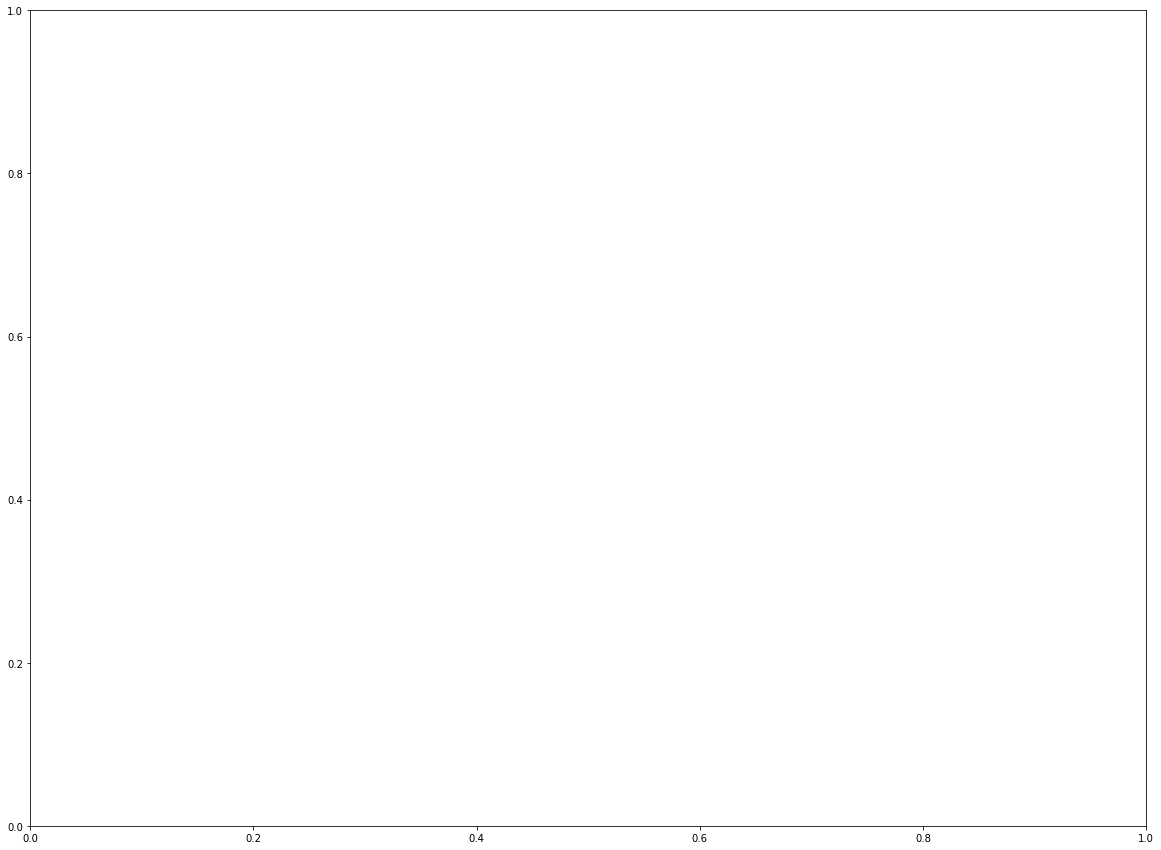

In [19]:
fig, ax = plt.subplots(figsize=(20,15))

In [20]:
sea.plot(ax=ax)
roads.plot(ax=ax,
           color="grey", 
           linewidth=1)
cycling_geo.plot(ax=ax)

ax.set_xlim(25475000, 25515000)
ax.set_ylim(6660000, 6700000)


(6660000.0, 6700000.0)

<Figure size 432x288 with 0 Axes>

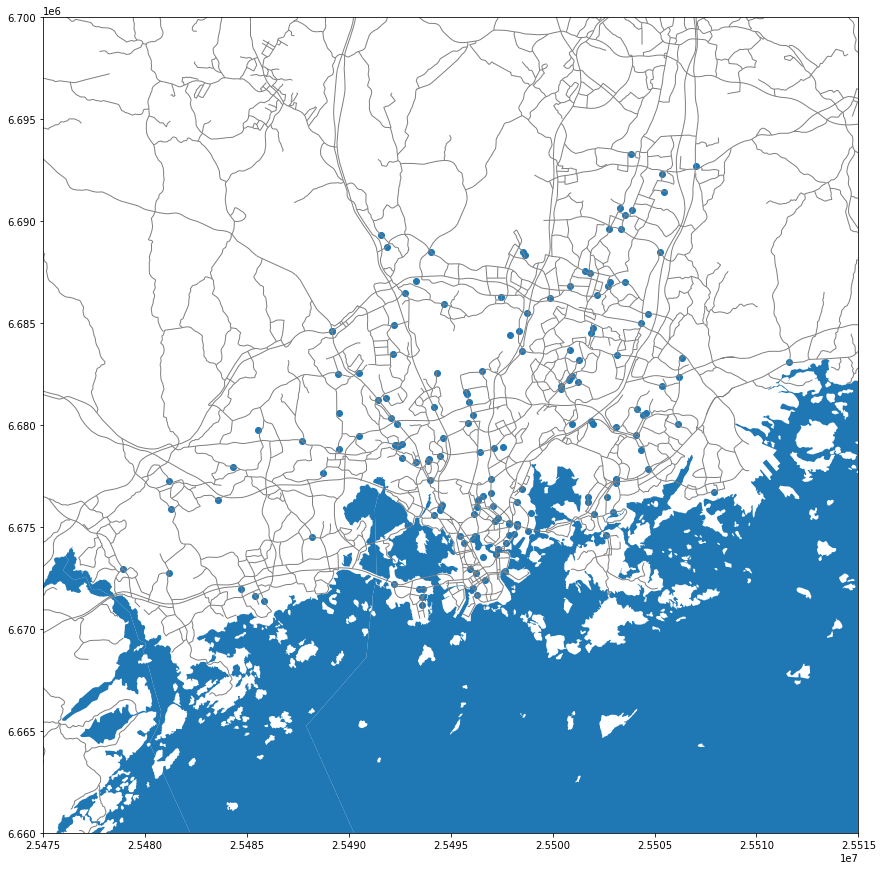

In [21]:
fig